# Meta Agent Analysis

Evaluating the suspicion-tracking MetaAgent against various opponents.

In [21]:
import sys
from pathlib import Path
import time
import pickle
import random
import json
from collections import defaultdict
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm

# Add paths
root = Path().absolute().parent.parent
sys.path.insert(0, str(root))
sys.path.insert(0, str(root / "shitler_env"))
sys.path.insert(0, str(root / "agents"))
sys.path.insert(0, str(root / "agents" / "cfr"))

In [22]:
from game import ShitlerEnv
from agent import SimpleRandomAgent, BaseAgent
from meta_agent import MetaAgent
from selfish_agent import SelfishAgent

## Configuration

In [23]:
NUM_GAMES = 16000
SEED = 42

print(f"Games per matchup: {NUM_GAMES}")
print(f"Seed: {SEED}")

Games per matchup: 16000
Seed: 42


## Helper Functions

In [24]:
def play_game(liberal_agent, fascist_agent, seed=None):
    """Play a single game and return results."""
    env = ShitlerEnv()
    env.reset(seed=seed)

    # Reset meta agent suspicion if applicable
    if hasattr(liberal_agent, 'reset_suspicion'):
        liberal_agent.reset_suspicion()
    if hasattr(fascist_agent, 'reset_suspicion'):
        fascist_agent.reset_suspicion()

    # Assign agents by role
    agents = {}
    for i, agent_name in enumerate(env.agents):
        role = env.roles[agent_name]
        if role == "lib":
            agents[agent_name] = liberal_agent
        else:
            agents[agent_name] = fascist_agent

    step = 0
    while not all(env.terminations.values()) and step < 1000:
        agent_name = env.agent_selection
        agent_idx = env.agents.index(agent_name)
        obs = env.observe(agent_name)
        action_space = env.action_space(agent_name)
        phase = env.phase

        action = agents[agent_name].get_action(
            obs, action_space, phase=phase, agent_idx=agent_idx
        )
        env.step(action)
        step += 1

    # Determine winner
    lib_win = False
    for agent_name, reward in env.rewards.items():
        if reward == 1:
            role = env.roles[agent_name]
            lib_win = (role == "lib")
            break

    # Win condition
    if lib_win:
        win_cond = "lib_5_policies" if env.lib_policies >= 5 else "hitler_executed"
    else:
        win_cond = "fasc_6_policies" if env.fasc_policies >= 6 else "hitler_chancellor"

    return {
        "lib_win": lib_win,
        "win_condition": win_cond,
        "lib_policies": env.lib_policies,
        "fasc_policies": env.fasc_policies,
        "steps": step,
    }

In [25]:
def wilson_ci(successes, total, confidence=0.95):
    """Calculate Wilson score confidence interval."""
    if total == 0:
        return 0, 0, 0

    p = successes / total
    z = stats.norm.ppf(1 - (1 - confidence) / 2)

    denominator = 1 + z**2 / total
    center = (p + z**2 / (2 * total)) / denominator
    margin = z * ((p * (1 - p) + z**2 / (4 * total)) / total) ** 0.5 / denominator

    return p, max(0, center - margin), min(1, center + margin)


def evaluate_matchup(liberal_agent, fascist_agent, num_games, seed=None, name=""):
    """Evaluate a matchup and return statistics."""
    results = {
        "lib_wins": 0,
        "fasc_wins": 0,
        "win_conditions": defaultdict(int),
        "total_lib_policies": 0,
        "total_fasc_policies": 0,
        "total_steps": 0,
    }

    for i in tqdm(range(num_games), desc=name):
        game_seed = seed + i if seed else None
        game_result = play_game(liberal_agent, fascist_agent, seed=game_seed)

        if game_result["lib_win"]:
            results["lib_wins"] += 1
        else:
            results["fasc_wins"] += 1

        results["win_conditions"][game_result["win_condition"]] += 1
        results["total_lib_policies"] += game_result["lib_policies"]
        results["total_fasc_policies"] += game_result["fasc_policies"]
        results["total_steps"] += game_result["steps"]

    # Calculate final stats
    results["lib_win_rate"] = results["lib_wins"] / num_games
    results["avg_lib_policies"] = results["total_lib_policies"] / num_games
    results["avg_fasc_policies"] = results["total_fasc_policies"] / num_games
    results["avg_steps"] = results["total_steps"] / num_games
    results["win_conditions"] = dict(results["win_conditions"])
    results["num_games"] = num_games
    
    # Add CI
    _, ci_low, ci_high = wilson_ci(results["lib_wins"], num_games)
    results["ci_low"] = ci_low
    results["ci_high"] = ci_high

    return results

## Initialize Agents

In [26]:
random_agent = SimpleRandomAgent()
selfish_agent = SelfishAgent()
meta_agent = MetaAgent(temperature=1.0)

print("Agents initialized:")
print("  - RandomAgent")
print("  - SelfishAgent")
print("  - MetaAgent (suspicion tracking)")

Agents initialized:
  - RandomAgent
  - SelfishAgent
  - MetaAgent (suspicion tracking)


In [27]:
# Try to load CFR agent
cfr_agent = None
cfr_checkpoint = root / "experiments" / "cfr" / "checkpoints" / "cfr_liberal_iter_350000.pkl"

if cfr_checkpoint.exists():
    try:
        from infoset import get_infoset_key
        
        class CFRAgent:
            def __init__(self, checkpoint_path):
                self.strategy_sums = defaultdict(lambda: defaultdict(float))
                with open(checkpoint_path, "rb") as f:
                    data = pickle.load(f)
                self.iterations = data.get("iterations", 0)
                for k, v in data["strategy_sums"].items():
                    for a, s in v.items():
                        self.strategy_sums[k][a] = s
                print(f"Loaded CFR: {self.iterations} iterations, {len(data['regret_sums'])} infosets")

            def get_average_strategy(self, infoset_key, legal_actions):
                strat_sums = self.strategy_sums[infoset_key]
                total = sum(strat_sums[a] for a in legal_actions)
                if total > 0:
                    return {a: strat_sums[a] / total for a in legal_actions}
                return {a: 1.0 / len(legal_actions) for a in legal_actions}

            def get_action(self, obs, action_space=None, **kwargs):
                phase = kwargs.get("phase", obs.get("phase", None))
                agent_idx = kwargs.get("agent_idx", 0)

                # Hard-code liberal card selection
                if phase in ["prez_cardsel", "chanc_cardsel"]:
                    mask = obs.get("card_action_mask", [1, 1])
                    return 1 if mask[1] == 1 else 0

                # Get legal actions
                legal_actions = None
                for mask_key in ["nomination_mask", "execution_mask", "card_action_mask"]:
                    if mask_key in obs:
                        legal_actions = [i for i, v in enumerate(obs[mask_key]) if v == 1]
                        break
                
                if not legal_actions:
                    return action_space.sample() if action_space else 0

                infoset_key = get_infoset_key(obs, phase, agent_idx)
                strategy = self.get_average_strategy(infoset_key, legal_actions)
                actions = list(strategy.keys())
                probs = [strategy[a] for a in actions]
                return random.choices(actions, weights=probs, k=1)[0]

        cfr_agent = CFRAgent(str(cfr_checkpoint))
        print("  - CFRAgent (loaded from checkpoint)")
    except Exception as e:
        print(f"Could not load CFR agent: {e}")
else:
    print(f"CFR checkpoint not found at {cfr_checkpoint}")

Loaded CFR: 350000 iterations, 3046252 infosets
  - CFRAgent (loaded from checkpoint)


In [28]:
# Try to load PPO agent
ppo_agent = None
ppo_checkpoint = root / "experiments" / "checkpoints_asymmetric" / "liberal" / "checkpoint_1000.pt"

if ppo_checkpoint.exists():
    try:
        import torch
        sys.path.insert(0, str(root / "agents" / "ppo"))
        from asymmetric_ppo_agent import AsymmetricPPOAgent
        from observation import ObservationProcessor
        from networks import PHASE_TO_IDX
        
        obs_processor = ObservationProcessor()
        obs_dim = obs_processor.obs_dim
        
        # Create agent and load checkpoint
        ppo_asymmetric = AsymmetricPPOAgent(
            obs_dim=obs_dim,
            train_team="liberal",
            hidden_dims=[128, 128],
            device="cpu"
        )
        ppo_asymmetric.load(str(ppo_checkpoint))
        
        # Wrapper class for evaluation
        class PPOAgentWrapper:
            def __init__(self, asymmetric_agent, obs_processor):
                self.agent = asymmetric_agent
                self.obs_processor = obs_processor
                self.env = None  # Will be set during game
            
            def get_action(self, obs, action_space=None, **kwargs):
                phase = kwargs.get("phase", "voting")
                
                # Hard-code liberal card selection (same as other agents)
                if phase in ["prez_cardsel", "chanc_cardsel"]:
                    mask = obs.get("card_action_mask", [1, 1])
                    return 1 if mask[1] == 1 else 0
                
                # Process observation
                obs_array = self.obs_processor.process(obs)
                phase_idx = PHASE_TO_IDX.get(phase, 0)
                
                # Get action mask
                if "nomination_mask" in obs:
                    action_mask = np.array(obs["nomination_mask"], dtype=np.float32)
                elif "execution_mask" in obs:
                    action_mask = np.array(obs["execution_mask"], dtype=np.float32)
                elif phase == "voting":
                    action_mask = np.ones(2, dtype=np.float32)
                elif phase == "prez_claim":
                    action_mask = np.ones(4, dtype=np.float32)
                elif phase == "chanc_claim":
                    action_mask = np.ones(3, dtype=np.float32)
                else:
                    action_mask = np.ones(2, dtype=np.float32)
                
                action, _, _ = self.agent.get_action(obs_array, phase_idx, action_mask, deterministic=True)
                return action
        
        ppo_agent = PPOAgentWrapper(ppo_asymmetric, obs_processor)
        print(f"  - PPOAgent (loaded from {ppo_checkpoint.name})")
    except Exception as e:
        print(f"Could not load PPO agent: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"PPO checkpoint not found at {ppo_checkpoint}")

Asymmetric training: liberal team trains, other team random
  - PPOAgent (loaded from checkpoint_1000.pt)


## Run Experiments

In [29]:
experiments = {}

In [30]:
# 1. Random vs Random (baseline)
print("1. Random vs Random (baseline)")
experiments["random_vs_random"] = evaluate_matchup(
    random_agent, random_agent, NUM_GAMES, SEED, "Random vs Random"
)
r = experiments["random_vs_random"]
print(f"   Lib win rate: {r['lib_win_rate']:.1%} (95% CI: {r['ci_low']:.1%}-{r['ci_high']:.1%})")
print(f"   Win conditions: {r['win_conditions']}")

1. Random vs Random (baseline)


Random vs Random: 100%|██████████| 16000/16000 [00:32<00:00, 493.89it/s]

   Lib win rate: 50.3% (95% CI: 49.5%-51.0%)
   Win conditions: {'hitler_chancellor': 6670, 'lib_5_policies': 5759, 'hitler_executed': 2283, 'fasc_6_policies': 1288}


In [31]:
# 2. Selfish Lib vs Random Fasc
print("2. Selfish Lib vs Random Fasc")
experiments["selfish_vs_random"] = evaluate_matchup(
    selfish_agent, random_agent, NUM_GAMES, SEED, "Selfish vs Random"
)
r = experiments["selfish_vs_random"]
print(f"   Lib win rate: {r['lib_win_rate']:.1%} (95% CI: {r['ci_low']:.1%}-{r['ci_high']:.1%})")
print(f"   Win conditions: {r['win_conditions']}")

2. Selfish Lib vs Random Fasc


Selfish vs Random: 100%|██████████| 16000/16000 [00:32<00:00, 493.81it/s]

   Lib win rate: 49.9% (95% CI: 49.1%-50.7%)
   Win conditions: {'lib_5_policies': 5766, 'hitler_chancellor': 6746, 'fasc_6_policies': 1272, 'hitler_executed': 2216}


In [32]:
# 3. META Lib vs Random Fasc
print("3. META Lib vs Random Fasc")
experiments["meta_vs_random"] = evaluate_matchup(
    meta_agent, random_agent, NUM_GAMES, SEED, "Meta vs Random"
)
r = experiments["meta_vs_random"]
print(f"   Lib win rate: {r['lib_win_rate']:.1%} (95% CI: {r['ci_low']:.1%}-{r['ci_high']:.1%})")
print(f"   Win conditions: {r['win_conditions']}")

3. META Lib vs Random Fasc


Meta vs Random: 100%|██████████| 16000/16000 [00:15<00:00, 1023.91it/s]

   Lib win rate: 67.6% (95% CI: 66.9%-68.3%)
   Win conditions: {'hitler_executed': 3300, 'lib_5_policies': 7518, 'hitler_chancellor': 4887, 'fasc_6_policies': 295}


In [33]:
# 4. META Lib vs Selfish Fasc
print("4. META Lib vs Selfish Fasc")
experiments["meta_vs_selfish"] = evaluate_matchup(
    meta_agent, selfish_agent, NUM_GAMES, SEED, "Meta vs Selfish"
)
r = experiments["meta_vs_selfish"]
print(f"   Lib win rate: {r['lib_win_rate']:.1%} (95% CI: {r['ci_low']:.1%}-{r['ci_high']:.1%})")
print(f"   Win conditions: {r['win_conditions']}")

4. META Lib vs Selfish Fasc


Meta vs Selfish: 100%|██████████| 16000/16000 [00:14<00:00, 1099.70it/s]

   Lib win rate: 49.2% (95% CI: 48.4%-49.9%)
   Win conditions: {'hitler_executed': 5498, 'hitler_chancellor': 7202, 'lib_5_policies': 2368, 'fasc_6_policies': 932}


In [34]:
# 5. Selfish vs Selfish
print("5. Selfish vs Selfish")
experiments["selfish_vs_selfish"] = evaluate_matchup(
    selfish_agent, selfish_agent, NUM_GAMES, SEED, "Selfish vs Selfish"
)
r = experiments["selfish_vs_selfish"]
print(f"   Lib win rate: {r['lib_win_rate']:.1%} (95% CI: {r['ci_low']:.1%}-{r['ci_high']:.1%})")
print(f"   Win conditions: {r['win_conditions']}")

5. Selfish vs Selfish


Selfish vs Selfish: 100%|██████████| 16000/16000 [00:29<00:00, 546.72it/s]

   Lib win rate: 29.1% (95% CI: 28.4%-29.8%)
   Win conditions: {'fasc_6_policies': 2514, 'hitler_executed': 3647, 'hitler_chancellor': 8829, 'lib_5_policies': 1010}


In [35]:
# 6. CFR vs Random (if available)
if cfr_agent:
    print("6. CFR Lib vs Random Fasc")
    experiments["cfr_vs_random"] = evaluate_matchup(
        cfr_agent, random_agent, NUM_GAMES, SEED, "CFR vs Random"
    )
    r = experiments["cfr_vs_random"]
    print(f"   Lib win rate: {r['lib_win_rate']:.1%} (95% CI: {r['ci_low']:.1%}-{r['ci_high']:.1%})")
    print(f"   Win conditions: {r['win_conditions']}")

6. CFR Lib vs Random Fasc


CFR vs Random: 100%|██████████| 16000/16000 [00:35<00:00, 448.46it/s]

   Lib win rate: 50.1% (95% CI: 49.3%-50.9%)
   Win conditions: {'hitler_executed': 2228, 'hitler_chancellor': 6739, 'lib_5_policies': 5790, 'fasc_6_policies': 1243}


In [36]:
# 7. CFR vs Selfish (if available)
if cfr_agent:
    print("7. CFR Lib vs Selfish Fasc")
    experiments["cfr_vs_selfish"] = evaluate_matchup(
        cfr_agent, selfish_agent, NUM_GAMES, SEED, "CFR vs Selfish"
    )
    r = experiments["cfr_vs_selfish"]
    print(f"   Lib win rate: {r['lib_win_rate']:.1%} (95% CI: {r['ci_low']:.1%}-{r['ci_high']:.1%})")
    print(f"   Win conditions: {r['win_conditions']}")

7. CFR Lib vs Selfish Fasc


CFR vs Selfish: 100%|██████████| 16000/16000 [00:33<00:00, 484.55it/s]

   Lib win rate: 28.1% (95% CI: 27.4%-28.8%)
   Win conditions: {'hitler_chancellor': 8939, 'lib_5_policies': 955, 'hitler_executed': 3545, 'fasc_6_policies': 2561}


In [37]:
# 8. PPO vs Random (if available)
if ppo_agent:
    print("8. PPO Lib vs Random Fasc")
    experiments["ppo_vs_random"] = evaluate_matchup(
        ppo_agent, random_agent, NUM_GAMES, SEED, "PPO vs Random"
    )
    r = experiments["ppo_vs_random"]
    print(f"   Lib win rate: {r['lib_win_rate']:.1%} (95% CI: {r['ci_low']:.1%}-{r['ci_high']:.1%})")
    print(f"   Win conditions: {r['win_conditions']}")

8. PPO Lib vs Random Fasc


PPO vs Random: 100%|██████████| 16000/16000 [03:56<00:00, 67.76it/s]

   Lib win rate: 51.3% (95% CI: 50.5%-52.1%)
   Win conditions: {'hitler_executed': 2727, 'hitler_chancellor': 6508, 'lib_5_policies': 5483, 'fasc_6_policies': 1282}


In [38]:
# 9. PPO vs Selfish (if available)
if ppo_agent:
    print("9. PPO Lib vs Selfish Fasc")
    experiments["ppo_vs_selfish"] = evaluate_matchup(
        ppo_agent, selfish_agent, NUM_GAMES, SEED, "PPO vs Selfish"
    )
    r = experiments["ppo_vs_selfish"]
    print(f"   Lib win rate: {r['lib_win_rate']:.1%} (95% CI: {r['ci_low']:.1%}-{r['ci_high']:.1%})")
    print(f"   Win conditions: {r['win_conditions']}")

9. PPO Lib vs Selfish Fasc


PPO vs Selfish: 100%|██████████| 16000/16000 [03:43<00:00, 71.71it/s]

   Lib win rate: 32.1% (95% CI: 31.4%-32.9%)
   Win conditions: {'lib_5_policies': 1094, 'hitler_chancellor': 8142, 'fasc_6_policies': 2714, 'hitler_executed': 4050}


## Visualization

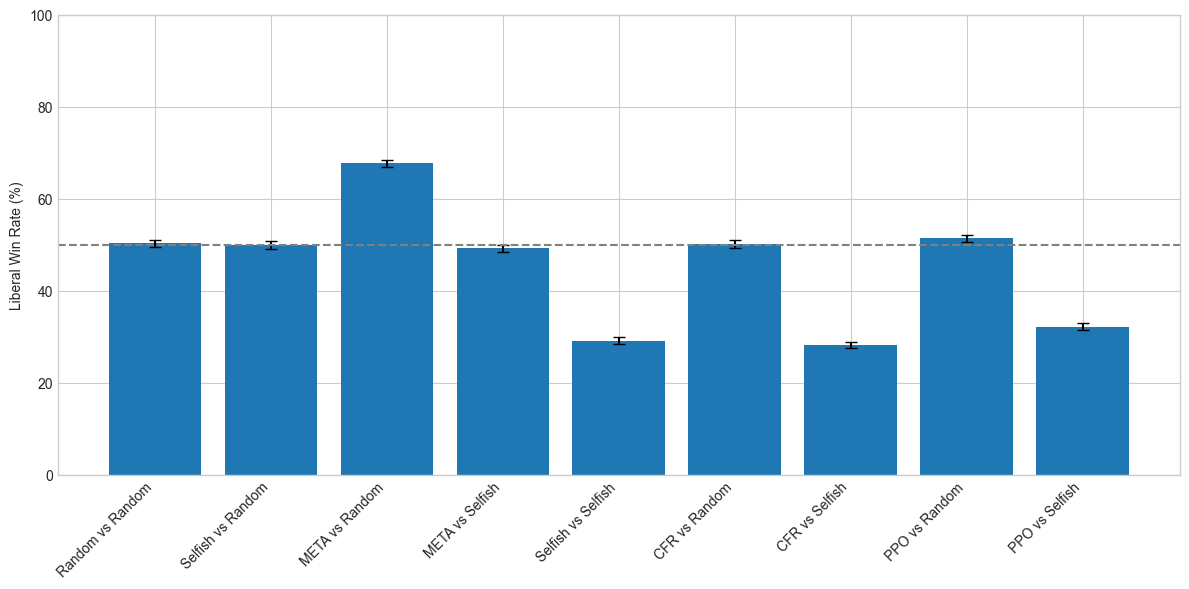

In [39]:
# Bar chart with confidence intervals
fig, ax = plt.subplots()

labels = []
win_rates = []
ci_lows = []
ci_highs = []

label_map = {
    "random_vs_random": "Random vs Random",
    "selfish_vs_random": "Selfish vs Random",
    "meta_vs_random": "META vs Random",
    "meta_vs_selfish": "META vs Selfish",
    "selfish_vs_selfish": "Selfish vs Selfish",
    "cfr_vs_random": "CFR vs Random",
    "cfr_vs_selfish": "CFR vs Selfish",
    "ppo_vs_random": "PPO vs Random",
    "ppo_vs_selfish": "PPO vs Selfish",
}

order = ["random_vs_random", "selfish_vs_random", "meta_vs_random", 
         "meta_vs_selfish", "selfish_vs_selfish", "cfr_vs_random", "cfr_vs_selfish",
         "ppo_vs_random", "ppo_vs_selfish"]

for key in order:
    if key in experiments:
        exp = experiments[key]
        labels.append(label_map[key])
        win_rates.append(exp["lib_win_rate"] * 100)
        ci_lows.append((exp["lib_win_rate"] - exp["ci_low"]) * 100)
        ci_highs.append((exp["ci_high"] - exp["lib_win_rate"]) * 100)

x = np.arange(len(labels))
ax.bar(x, win_rates, yerr=[ci_lows, ci_highs], capsize=4)
ax.axhline(y=50, color='gray', linestyle='--')
ax.set_ylabel('Liberal Win Rate (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('meta_win_rates.png', dpi=150)
plt.show()

## Summary Table

In [ ]:
rows = []
for key, exp in experiments.items():
    rows.append({
        "Matchup": label_map.get(key, key),
        "Lib Win Rate": f"{exp['lib_win_rate']:.1%}",
        "95% CI": f"({exp['ci_low']:.1%} - {exp['ci_high']:.1%})",
        "Lib Wins": exp['lib_wins'],
        "Fasc Wins": exp['fasc_wins'],
        "Avg Lib Pol": f"{exp['avg_lib_policies']:.2f}",
        "Avg Fasc Pol": f"{exp['avg_fasc_policies']:.2f}",
    })

df = pd.DataFrame(rows)
df

## Statistical Significance

In [ ]:
from scipy.stats import chi2_contingency

def compare_experiments(exp1_key, exp2_key):
    """Chi-square test for difference in win rates."""
    exp1 = experiments[exp1_key]
    exp2 = experiments[exp2_key]
    
    table = [
        [exp1['lib_wins'], exp1['fasc_wins']],
        [exp2['lib_wins'], exp2['fasc_wins']]
    ]
    
    chi2, p_value, dof, expected = chi2_contingency(table)
    diff = exp1['lib_win_rate'] - exp2['lib_win_rate']
    
    return {
        'exp1': label_map.get(exp1_key, exp1_key),
        'exp2': label_map.get(exp2_key, exp2_key),
        'diff': diff,
        'chi2': chi2,
        'p_value': p_value,
        'significant': p_value < 0.05,
    }

print("Statistical Significance Tests (Chi-Square, α=0.05)")
print("=" * 70)

comparisons = [
    ("meta_vs_random", "random_vs_random"),
    ("meta_vs_random", "selfish_vs_random"),
    ("meta_vs_selfish", "selfish_vs_selfish"),
]

if "cfr_vs_random" in experiments:
    comparisons.append(("meta_vs_random", "cfr_vs_random"))

for exp1, exp2 in comparisons:
    if exp1 in experiments and exp2 in experiments:
        result = compare_experiments(exp1, exp2)
        sig = "*" if result['significant'] else ""
        print(f"{result['exp1']} vs {result['exp2']}:")
        print(f"  Difference: {result['diff']*100:+.1f}% | p-value: {result['p_value']:.4f} {sig}")
        print()

## Analysis

In [ ]:
print("ANALYSIS")
print("=" * 50)

baseline = experiments["random_vs_random"]["lib_win_rate"]
print(f"Baseline (Random vs Random): {baseline:.1%}")
print()

for name in ["selfish_vs_random", "meta_vs_random", "cfr_vs_random", "ppo_vs_random"]:
    if name in experiments:
        rate = experiments[name]["lib_win_rate"]
        diff = (rate - baseline) * 100
        label = name.split("_")[0].upper()
        print(f"{label} improvement over baseline: {diff:+.1f}%")

print()

if "meta_vs_random" in experiments and "selfish_vs_random" in experiments:
    meta_rate = experiments["meta_vs_random"]["lib_win_rate"]
    selfish_rate = experiments["selfish_vs_random"]["lib_win_rate"]
    diff = (meta_rate - selfish_rate) * 100
    if diff > 0:
        print(f"META beats Selfish by: {diff:.1f}%")
    elif diff < 0:
        print(f"Selfish beats META by: {-diff:.1f}%")
    else:
        print("META and Selfish are tied")

if "cfr_vs_random" in experiments and "meta_vs_random" in experiments:
    cfr_rate = experiments["cfr_vs_random"]["lib_win_rate"]
    meta_rate = experiments["meta_vs_random"]["lib_win_rate"]
    diff = (meta_rate - cfr_rate) * 100
    if diff > 0:
        print(f"META beats CFR by: {diff:.1f}%")
    elif diff < 0:
        print(f"CFR beats META by: {-diff:.1f}%")
    else:
        print("META and CFR are tied")

if "ppo_vs_random" in experiments and "meta_vs_random" in experiments:
    ppo_rate = experiments["ppo_vs_random"]["lib_win_rate"]
    meta_rate = experiments["meta_vs_random"]["lib_win_rate"]
    diff = (meta_rate - ppo_rate) * 100
    if diff > 0:
        print(f"META beats PPO by: {diff:.1f}%")
    elif diff < 0:
        print(f"PPO beats META by: {-diff:.1f}%")
    else:
        print("META and PPO are tied")

## Save Results

In [ ]:
# Create results directory
results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

# Save to JSON
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output = {
    "metadata": {
        "num_games": NUM_GAMES,
        "seed": SEED,
        "timestamp": timestamp,
    },
    "results": experiments,
}

with open(results_dir / f"meta_analysis_{timestamp}.json", "w") as f:
    json.dump(output, f, indent=2)

print(f"Results saved to results/meta_analysis_{timestamp}.json")